In [ ]:
!pip3 install datasets
!pip install textstat
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.5 MB/s eta 0:00:00


In [ ]:
# System & Environment
import os
import random
import ast
import json

# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - Modeling & Evaluation
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# Sparse matrix handling
from scipy.sparse import hstack, csr_matrix, issparse

# Readability / Linguistic Features
import textstat

# SHAP Interpretability
import shap

# Colab-specific
from google.colab import drive

# Set reproducibility
random.seed(42)
np.random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"

# Mount Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation ARC (https://www.kaggle.com/datasets/jeromeblanchet/arc-ai2-reasoning-challenge/data)

In [ ]:
# Load CSV
df = pd.read_csv("/content/drive/My Drive/Master Thesis/ARC/Confidence/arc_confidence.csv")

# Drop rows with any critical missing values
required_columns = ["question", "choices", "answer_text", "true_label", "grade_group", "entropy", "confidence_correct"]
df = df.dropna(subset=required_columns)

# Convert stringified list to list for 'choices' column
if isinstance(df.loc[0, "choices"], str) and df.loc[0, "choices"].startswith("["):
    df["choices"] = df["choices"].apply(ast.literal_eval)

# Reset index for K-Fold use
df = df.sort_values("id").reset_index(drop=True)

# Quick check
df.head()

,id,question,choices,answer_key,difficulty,grade,grade_group,answer_text,entropy,confidence_correct,true_label
0,ACTAAP_2007_7_22,Which is the function of the gallbladder?,"[store bile, produce bile, store digestive enz...",A,easy,7,upper,store bile,0.304082,0.897548,0
1,ACTAAP_2007_7_26,"A mineral sample is obtained from a box, and a...","[Return the mineral to its box., Rinse the min...",B,easy,7,upper,"Rinse the mineral with water, dry it, and retu...",0.680800,0.565425,1
2,ACTAAP_2007_7_3,A student is investigating the temperature at ...,"[Rain falls from the sky., The sky is clear of...",D,challenge,7,upper,Water droplets disappear from the grass.,0.401502,0.784638,3
3,ACTAAP_2007_7_30,Which best describes a scientific theory?,"[It is still being tested., It is true, once w...",A,easy,7,upper,It is still being tested.,0.264128,0.902152,0
4,ACTAAP_2008_5_15,Which is true of a car that is accelerating al...,"[Its kinetic energy is increasing, Its kinetic...",A,easy,5,lower,Its kinetic energy is increasing,0.079459,0.979453,0


# Baseline

### Majority Class Baseline

In [ ]:
def majority_class_baseline(df):
    most_common = df["grade_group"].value_counts().idxmax()
    baseline_acc = df["grade_group"].value_counts().max() / len(df) * 100
    print(f"Majority Class Baseline: Always Predict '{most_common}' → Accuracy: {baseline_acc:.2f}%")

print("ARC Dataset Majority Class Baseline:")
majority_class_baseline(df)

ARC Dataset Majority Class Baseline:
Majority Class Baseline: Always Predict 'upper' → Accuracy: 64.22%


In [ ]:
def majority_class_macro_f1(y_true):
    most_common = y_true.value_counts().idxmax()
    y_pred = [most_common] * len(y_true)
    return most_common, f1_score(y_true, y_pred, average='macro')

# Run it on the test set
most_common, macro_f1_baseline = majority_class_macro_f1(df["grade_group"])
print(f"Majority Class Baseline (Macro F1): Always Predict '{most_common}' → F1-Score: {macro_f1_baseline:.4f}")

Majority Class Baseline (Macro F1): Always Predict 'upper' → F1-Score: 0.3911


#### Baseline

In [ ]:
def vectorize_data(train_df, test_df):
    # Vectorizes combined text (question + choices) using TF-IDF.
    train_df["combined_text"] = train_df["question"] + " " + train_df["choices"].apply(lambda x: " ".join(x))
    test_df["combined_text"] = test_df["question"] + " " + test_df["choices"].apply(lambda x: " ".join(x))

    vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
    X_train = vectorizer.fit_transform(train_df["combined_text"])
    X_test = vectorizer.transform(test_df["combined_text"])

    y_train = train_df["grade_group"]
    y_test = test_df["grade_group"]

    return X_train, X_test, y_train, y_test, vectorizer

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM": LinearSVC(random_state=42)
}

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
for model_name, model in models.items():
    print(f"\n=== {model_name} ({k}-Fold Average) ===")
    all_preds = []
    all_targets = []

    for train_idx, test_idx in skf.split(df["question"], df["grade_group"]):
        train_df = df.iloc[train_idx].copy()
        test_df = df.iloc[test_idx].copy()

        X_train, X_test, y_train, y_test, vectorizer = vectorize_data(train_df, test_df)

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        all_preds.extend(preds)
        all_targets.extend(y_test)

    acc = accuracy_score(all_targets, all_preds)
    print(f"Average Accuracy: {acc:.4f}")
    print(classification_report(all_targets, all_preds, zero_division=0))



=== Logistic Regression (5-Fold Average) ===
Average Accuracy: 0.7123
              precision    recall  f1-score   support

       lower       0.59      0.64      0.61       536
       upper       0.79      0.75      0.77       962

    accuracy                           0.71      1498
   macro avg       0.69      0.70      0.69      1498
weighted avg       0.72      0.71      0.71      1498


=== Naive Bayes (5-Fold Average) ===
Average Accuracy: 0.7089
              precision    recall  f1-score   support

       lower       0.81      0.24      0.37       536
       upper       0.70      0.97      0.81       962

    accuracy                           0.71      1498
   macro avg       0.75      0.61      0.59      1498
weighted avg       0.74      0.71      0.65      1498


=== Decision Tree (5-Fold Average) ===
Average Accuracy: 0.6195
              precision    recall  f1-score   support

       lower       0.47      0.51      0.49       536
       upper       0.71      0.68     

# Baseline Confidence and Entropy

In [ ]:
def vectorize_entropy_only(train_df, test_df):
    for col in ["entropy"]:
        train_df[col] = train_df[col].fillna(0)
        test_df[col] = test_df[col].fillna(0)

    X_train = csr_matrix(train_df[["entropy"]].values)
    X_test = csr_matrix(test_df[["entropy"]].values)
    y_train = train_df["grade_group"]
    y_test = test_df["grade_group"]

    return X_train, X_test, y_train, y_test

def vectorize_confidence_only(train_df, test_df):
    for col in ["confidence_correct"]:
        train_df[col] = train_df[col].fillna(0)
        test_df[col] = test_df[col].fillna(0)

    X_train = csr_matrix(train_df[["confidence_correct"]].values)
    X_test = csr_matrix(test_df[["confidence_correct"]].values)
    y_train = train_df["grade_group"]
    y_test = test_df["grade_group"]

    return X_train, X_test, y_train, y_test

def vectorize_entropy_confidence(train_df, test_df):
    for col in ["entropy", "confidence_correct"]:
        train_df[col] = train_df[col].fillna(0)
        test_df[col] = test_df[col].fillna(0)

    X_train = csr_matrix(train_df[["entropy", "confidence_correct"]].values)
    X_test = csr_matrix(test_df[["entropy", "confidence_correct"]].values)
    y_train = train_df["grade_group"]
    y_test = test_df["grade_group"]

    return X_train, X_test, y_train, y_test


In [ ]:
improved_models = {
    "Logistic Regression": LogisticRegression(C=0.05, class_weight="balanced", max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier(),
    "SVM": LinearSVC(random_state=42),
    "Decision Tree": DecisionTreeClassifier(
        class_weight="balanced",
        max_depth=20,
        min_samples_leaf=3,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        class_weight="balanced",
        n_estimators=300,
        max_depth=15,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
}


vectorizers = {
    "Only Entropy": vectorize_entropy_only,
    "Only Confidence": vectorize_confidence_only,
    "Entropy + Confidence": vectorize_entropy_confidence
}

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

for setting_name, vectorizer_fn in vectorizers.items():
    print(f"\n=== {setting_name} | ({k}-Fold Average) ===")

    for model_name, model in improved_models.items():
        all_preds = []
        all_targets = []

        for train_idx, test_idx in skf.split(df["question"], df["grade_group"]):
            train_df = df.iloc[train_idx].copy()
            test_df = df.iloc[test_idx].copy()

            X_train, X_test, y_train, y_test = vectorizer_fn(train_df, test_df)

            model.fit(X_train, y_train)
            preds = model.predict(X_test)

            all_preds.extend(preds)
            all_targets.extend(y_test)

        acc = accuracy_score(all_targets, all_preds)
        print(f"\n{model_name} | Accuracy: {acc:.4f}")
        print(classification_report(all_targets, all_preds, zero_division=0))


=== Only Entropy | (5-Fold Average) ===

Logistic Regression | Accuracy: 0.5374
              precision    recall  f1-score   support

       lower       0.39      0.55      0.46       536
       upper       0.68      0.53      0.60       962

    accuracy                           0.54      1498
   macro avg       0.54      0.54      0.53      1498
weighted avg       0.58      0.54      0.55      1498


Naive Bayes | Accuracy: 0.6422
              precision    recall  f1-score   support

       lower       0.00      0.00      0.00       536
       upper       0.64      1.00      0.78       962

    accuracy                           0.64      1498
   macro avg       0.32      0.50      0.39      1498
weighted avg       0.41      0.64      0.50      1498


KNN | Accuracy: 0.5688
              precision    recall  f1-score   support

       lower       0.35      0.23      0.28       536
       upper       0.64      0.76      0.69       962

    accuracy                           0.57  

### Improving the Baseline Model

*   Lowering C value in LR to fix under-regularization.

Fix overfitting for Tree Models (good for feature importance):

*  max_depth=5 Limits depth prevents the tree from growing too deep and memorizing
*  min_samples_leaf=10 each leaf must have at least 10 examples, reducing splits on noise
*  n_estimators=100 (RF) More trees helps Random Forest generalize better by averaging

In [ ]:
improved_models = {
    "Logistic Regression": LogisticRegression(C=0.05, class_weight="balanced", max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier(),
    "SVM": LinearSVC(random_state=42),
    "Decision Tree": DecisionTreeClassifier(
        class_weight="balanced",
        max_depth=20,
        min_samples_leaf=3,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        class_weight="balanced",
        n_estimators=300,
        max_depth=15,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
}

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
for model_name, model in improved_models.items():
    print(f"\n=== {model_name} (Improved | {k}-Fold Average) ===")
    all_preds = []
    all_targets = []

    for train_idx, test_idx in skf.split(df["question"], df["grade_group"]):
        train_df = df.iloc[train_idx].copy()
        test_df = df.iloc[test_idx].copy()

        X_train, X_test, y_train, y_test, vectorizer = vectorize_data(train_df, test_df)

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        all_preds.extend(preds)
        all_targets.extend(y_test)

    acc = accuracy_score(all_targets, all_preds)
    print(f"Average Accuracy: {acc:.4f}")
    print(classification_report(all_targets, all_preds, zero_division=0))



=== Logistic Regression (Improved | 5-Fold Average) ===
Average Accuracy: 0.6996
              precision    recall  f1-score   support

       lower       0.57      0.67      0.61       536
       upper       0.80      0.72      0.75       962

    accuracy                           0.70      1498
   macro avg       0.68      0.69      0.68      1498
weighted avg       0.71      0.70      0.70      1498


=== Naive Bayes (Improved | 5-Fold Average) ===
Average Accuracy: 0.7089
              precision    recall  f1-score   support

       lower       0.81      0.24      0.37       536
       upper       0.70      0.97      0.81       962

    accuracy                           0.71      1498
   macro avg       0.75      0.61      0.59      1498
weighted avg       0.74      0.71      0.65      1498


=== KNN (Improved | 5-Fold Average) ===
Average Accuracy: 0.7003
              precision    recall  f1-score   support

       lower       0.59      0.53      0.56       536
       upper   

#Baseline with Entropy

In [ ]:
def vectorize_and_add_entropy(train_df, test_df):
    # Vectorizes text using TF-IDF and adds handcrafted + entropy/confidence features.
    for col in ["entropy"]:
        train_df[col] = train_df[col].fillna(0)
        test_df[col] = test_df[col].fillna(0)

    # Combine question + choices
    train_df["combined_text"] = train_df["question"] + " " + train_df["choices"].apply(lambda x: " ".join(x))
    test_df["combined_text"] = test_df["question"] + " " + test_df["choices"].apply(lambda x: " ".join(x))

    # TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
    X_train_text = vectorizer.fit_transform(train_df["combined_text"])
    X_test_text = vectorizer.transform(test_df["combined_text"])

    # Final list of extra features
    feature_cols = ["entropy"]

    X_train_features = train_df[feature_cols].values
    X_test_features = test_df[feature_cols].values

    # Combine sparse (TF-IDF) and dense (handcrafted) features
    X_train = hstack([X_train_text, X_train_features])
    X_test = hstack([X_test_text, X_test_features])

    y_train = train_df["grade_group"]
    y_test = test_df["grade_group"]

    return X_train, X_test, y_train, y_test, vectorizer

In [ ]:
improved_models = {
    "Logistic Regression": LogisticRegression(C=0.05, class_weight="balanced", max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier(),
    "SVM": LinearSVC(random_state=42),
    "Decision Tree": DecisionTreeClassifier(
        class_weight="balanced",
        max_depth=20,
        min_samples_leaf=3,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        class_weight="balanced",
        n_estimators=300,
        max_depth=15,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
}

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
for model_name, model in improved_models.items():
    print(f"\n=== {model_name} (Improved + Entropy | {k}-Fold Average) ===")
    all_preds = []
    all_targets = []

    for train_idx, test_idx in skf.split(df["question"], df["grade_group"]):
        train_df = df.iloc[train_idx].copy()
        test_df = df.iloc[test_idx].copy()

        X_train, X_test, y_train, y_test, vectorizer = vectorize_and_add_entropy(train_df, test_df)

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        all_preds.extend(preds)
        all_targets.extend(y_test)

    acc = accuracy_score(all_targets, all_preds)
    print(f"Average Accuracy: {acc:.4f}")
    print(classification_report(all_targets, all_preds, zero_division=0))


=== Logistic Regression (Improved + Entropy | 5-Fold Average) ===
Average Accuracy: 0.5841
              precision    recall  f1-score   support

       lower       0.44      0.58      0.50       536
       upper       0.71      0.59      0.65       962

    accuracy                           0.58      1498
   macro avg       0.58      0.58      0.57      1498
weighted avg       0.62      0.58      0.59      1498


=== Naive Bayes (Improved + Entropy | 5-Fold Average) ===
Average Accuracy: 0.6909
              precision    recall  f1-score   support

       lower       0.85      0.16      0.28       536
       upper       0.68      0.98      0.80       962

    accuracy                           0.69      1498
   macro avg       0.77      0.57      0.54      1498
weighted avg       0.74      0.69      0.61      1498


=== KNN (Improved + Entropy | 5-Fold Average) ===
Average Accuracy: 0.6776
              precision    recall  f1-score   support

       lower       0.56      0.49      

# Baseline with Confidence

In [ ]:
def vectorize_and_add_confidence_correct(train_df, test_df):
    # Vectorizes text using TF-IDF and adds handcrafted + confidence_correct/confidence features.

    for col in ["confidence_correct"]:
        train_df[col] = train_df[col].fillna(0)
        test_df[col] = test_df[col].fillna(0)

    # Combine question + choices
    train_df["combined_text"] = train_df["question"] + " " + train_df["choices"].apply(lambda x: " ".join(x))
    test_df["combined_text"] = test_df["question"] + " " + test_df["choices"].apply(lambda x: " ".join(x))

    # TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
    X_train_text = vectorizer.fit_transform(train_df["combined_text"])
    X_test_text = vectorizer.transform(test_df["combined_text"])

    # Final list of extra features
    feature_cols = ["confidence_correct"]

    X_train_features = train_df[feature_cols].values
    X_test_features = test_df[feature_cols].values

    # Combine sparse (TF-IDF) and dense (handcrafted) features
    X_train = hstack([X_train_text, X_train_features])
    X_test = hstack([X_test_text, X_test_features])

    y_train = train_df["grade_group"]
    y_test = test_df["grade_group"]

    return X_train, X_test, y_train, y_test, vectorizer

In [ ]:
improved_models = {
    "Logistic Regression": LogisticRegression(C=0.05, class_weight="balanced", max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier(),
    "SVM": LinearSVC(random_state=42),
    "Decision Tree": DecisionTreeClassifier(
        class_weight="balanced",
        max_depth=20,
        min_samples_leaf=3,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        class_weight="balanced",
        n_estimators=300,
        max_depth=15,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
}

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
for model_name, model in improved_models.items():
    print(f"\n=== {model_name} (Improved + Confidence| {k}-Fold Average) ===")
    all_preds = []
    all_targets = []

    for train_idx, test_idx in skf.split(df["question"], df["grade_group"]):
        train_df = df.iloc[train_idx].copy()
        test_df = df.iloc[test_idx].copy()

        X_train, X_test, y_train, y_test, vectorizer = vectorize_and_add_confidence_correct(train_df, test_df)

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        all_preds.extend(preds)
        all_targets.extend(y_test)

    acc = accuracy_score(all_targets, all_preds)
    print(f"Average Accuracy: {acc:.4f}")
    print(classification_report(all_targets, all_preds, zero_division=0))


=== Logistic Regression (Improved + Confidence| 5-Fold Average) ===
Average Accuracy: 0.5821
              precision    recall  f1-score   support

       lower       0.44      0.68      0.54       536
       upper       0.75      0.53      0.62       962

    accuracy                           0.58      1498
   macro avg       0.60      0.60      0.58      1498
weighted avg       0.64      0.58      0.59      1498


=== Naive Bayes (Improved + Confidence| 5-Fold Average) ===
Average Accuracy: 0.6949
              precision    recall  f1-score   support

       lower       0.82      0.19      0.31       536
       upper       0.68      0.98      0.80       962

    accuracy                           0.69      1498
   macro avg       0.75      0.58      0.56      1498
weighted avg       0.73      0.69      0.63      1498


=== KNN (Improved + Confidence| 5-Fold Average) ===
Average Accuracy: 0.6862
              precision    recall  f1-score   support

       lower       0.57      0.52

#Baseline with Entropy and Confidence

In [ ]:
def vectorize_and_add_entropy_confidence_correct(train_df, test_df):
    # Vectorizes text using TF-IDF and adds handcrafted + entropy/confidence features.
    for col in ["entropy", "confidence_correct"]:
        train_df[col] = train_df[col].fillna(0)
        test_df[col] = test_df[col].fillna(0)

    # Combine question + choices
    train_df["combined_text"] = train_df["question"] + " " + train_df["choices"].apply(lambda x: " ".join(x))
    test_df["combined_text"] = test_df["question"] + " " + test_df["choices"].apply(lambda x: " ".join(x))

    # TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
    X_train_text = vectorizer.fit_transform(train_df["combined_text"])
    X_test_text = vectorizer.transform(test_df["combined_text"])

    # Final list of extra features
    feature_cols = ["entropy", "confidence_correct"]

    X_train_features = train_df[feature_cols].values
    X_test_features = test_df[feature_cols].values

    # Combine sparse (TF-IDF) and dense (handcrafted) features
    X_train = hstack([X_train_text, X_train_features])
    X_test = hstack([X_test_text, X_test_features])

    y_train = train_df["grade_group"]
    y_test = test_df["grade_group"]

    return X_train, X_test, y_train, y_test, vectorizer

In [ ]:
improved_models = {
    "Logistic Regression": LogisticRegression(C=0.05, class_weight="balanced", max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier(),
    "SVM": LinearSVC(random_state=42),
    "Decision Tree": DecisionTreeClassifier(
        class_weight="balanced",
        max_depth=20,
        min_samples_leaf=3,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        class_weight="balanced",
        n_estimators=300,
        max_depth=15,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
}

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
for model_name, model in improved_models.items():
    print(f"\n=== {model_name} (Improved + Entropy and Confidence| {k}-Fold Average) ===")
    all_preds = []
    all_targets = []

    for train_idx, test_idx in skf.split(df["question"], df["grade_group"]):
        train_df = df.iloc[train_idx].copy()
        test_df = df.iloc[test_idx].copy()

        X_train, X_test, y_train, y_test, vectorizer = vectorize_and_add_entropy_confidence_correct(train_df, test_df)

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        all_preds.extend(preds)
        all_targets.extend(y_test)

    acc = accuracy_score(all_targets, all_preds)
    print(f"Average Accuracy: {acc:.4f}")
    print(classification_report(all_targets, all_preds, zero_division=0))


=== Logistic Regression (Improved + Entropy and Confidence| 5-Fold Average) ===
Average Accuracy: 0.5721
              precision    recall  f1-score   support

       lower       0.43      0.61      0.51       536
       upper       0.72      0.55      0.62       962

    accuracy                           0.57      1498
   macro avg       0.57      0.58      0.56      1498
weighted avg       0.62      0.57      0.58      1498


=== Naive Bayes (Improved + Entropy and Confidence| 5-Fold Average) ===
Average Accuracy: 0.6762
              precision    recall  f1-score   support

       lower       0.84      0.12      0.21       536
       upper       0.67      0.99      0.80       962

    accuracy                           0.68      1498
   macro avg       0.75      0.55      0.50      1498
weighted avg       0.73      0.68      0.59      1498


=== KNN (Improved + Entropy and Confidence| 5-Fold Average) ===
Average Accuracy: 0.6749
              precision    recall  f1-score   suppor

#Extra Features

## Length-based

*   Question Length
*   Average Choice Length



In [ ]:
def count_words(text):
    # Returns the number of words in a string.
    return len(text.split()) if isinstance(text, str) else 0

def avg_choice_length(choices):
    # Returns the average number of words across all choices (list of strings).
    if isinstance(choices, list) and all(isinstance(c, str) for c in choices):
        lengths = [count_words(c) for c in choices]
        return sum(lengths) / len(lengths) if lengths else 0
    return 0

def extract_length_features(df):
    # Adds word count features for question, answer, and choices.
    df["question_length"] = df["question"].apply(count_words)
    df["avg_choice_length"] = df["choices"].apply(avg_choice_length)

    return df


## Lexical Complexity


*   Average Word Length
*   Lexical Diversity (unique words/total words)



In [ ]:
def average_word_length(text):
    # Returns the average word length in a given text.
    if isinstance(text, str):
        words = text.split()
        return sum(len(word) for word in words) / len(words) if words else 0
    return 0

def lexical_diversity(text):
    # Returns the lexical diversity (unique words / total words) in a given text.
    if isinstance(text, str):
        words = text.split()
        return len(set(words)) / len(words) if words else 0
    return 0

def extract_lexical_features(df):
    # Adds lexical complexity features like avg word length and lexical diversity.
    df["avg_word_length"] = df["question"].apply(average_word_length)
    df["lexical_diversity"] = df["question"].apply(lexical_diversity)

    return df



## Readability Features

*   Flesch Reading Ease Score (Higher = Easier)
*   Flesch-Kincaid Grade Level (Higher = Harder)



In [ ]:
def calculate_flesch_reading_ease(text):
    return max(textstat.flesch_reading_ease(text), 0) if isinstance(text, str) else 0

def calculate_flesch_kincaid_grade(text):
    return max(textstat.flesch_kincaid_grade(text), 0) if isinstance(text, str) else 0

def extract_readability_features(df):
    # Adds readability features to the dataframe.
    df["flesch_reading_ease"] = df["question"].apply(calculate_flesch_reading_ease)
    df["flesch_kincaid_grade"] = df["question"].apply(calculate_flesch_kincaid_grade)

    return df

## Baseline with Features

In [ ]:
def vectorize_and_add_features(train_df, test_df):
    # Vectorizes text using TF-IDF and adds handcrafted + entropy/confidence features.
    train_df = extract_length_features(train_df)
    test_df = extract_length_features(test_df)

    train_df = extract_lexical_features(train_df)
    test_df = extract_lexical_features(test_df)

    train_df = extract_readability_features(train_df)
    test_df = extract_readability_features(test_df)

    for col in ["entropy", "confidence_correct"]:
        train_df[col] = train_df[col].fillna(0)
        test_df[col] = test_df[col].fillna(0)

    # Combine question + choices
    train_df["combined_text"] = train_df["question"] + " " + train_df["choices"].apply(lambda x: " ".join(x))
    test_df["combined_text"] = test_df["question"] + " " + test_df["choices"].apply(lambda x: " ".join(x))

    # TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
    X_train_text = vectorizer.fit_transform(train_df["combined_text"])
    X_test_text = vectorizer.transform(test_df["combined_text"])

    # Final list of extra features
    feature_cols = [
        "question_length", "avg_choice_length",
        "flesch_reading_ease", "flesch_kincaid_grade",
        "avg_word_length", "lexical_diversity",
        "entropy", "confidence_correct"
    ]

    X_train_features = train_df[feature_cols].values
    X_test_features = test_df[feature_cols].values

    # Combine sparse (TF-IDF) and dense (handcrafted) features
    X_train = hstack([X_train_text, X_train_features])
    X_test = hstack([X_test_text, X_test_features])

    y_train = train_df["grade_group"]
    y_test = test_df["grade_group"]

    return X_train, X_test, y_train, y_test, vectorizer


In [ ]:
improved_models = {
    "Logistic Regression": LogisticRegression(C=0.05, class_weight="balanced", max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier(),
    "SVM": LinearSVC(random_state=42),
    "Decision Tree": DecisionTreeClassifier(
        class_weight="balanced",
        max_depth=20,
        min_samples_leaf=3,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        class_weight="balanced",
        n_estimators=300,
        max_depth=15,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
}

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
for model_name, model in improved_models.items():
    print(f"\n=== {model_name} (Improved + Extra Features | {k}-Fold Average) ===")
    all_preds = []
    all_targets = []

    for train_idx, test_idx in skf.split(df["question"], df["grade_group"]):
        train_df = df.iloc[train_idx].copy()
        test_df = df.iloc[test_idx].copy()

        X_train, X_test, y_train, y_test, vectorizer = vectorize_and_add_features(train_df, test_df)

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        all_preds.extend(preds)
        all_targets.extend(y_test)

    acc = accuracy_score(all_targets, all_preds)
    print(f"Average Accuracy: {acc:.4f}")
    print(classification_report(all_targets, all_preds, zero_division=0))



=== Logistic Regression (Improved + Extra Features | 5-Fold Average) ===
Average Accuracy: 0.6569
              precision    recall  f1-score   support

       lower       0.52      0.65      0.58       536
       upper       0.77      0.66      0.71       962

    accuracy                           0.66      1498
   macro avg       0.64      0.66      0.64      1498
weighted avg       0.68      0.66      0.66      1498


=== Naive Bayes (Improved + Extra Features | 5-Fold Average) ===
Average Accuracy: 0.6969
              precision    recall  f1-score   support

       lower       0.61      0.42      0.50       536
       upper       0.72      0.85      0.78       962

    accuracy                           0.70      1498
   macro avg       0.67      0.64      0.64      1498
weighted avg       0.68      0.70      0.68      1498


=== KNN (Improved + Extra Features | 5-Fold Average) ===
Average Accuracy: 0.6409
              precision    recall  f1-score   support

       lower      

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Average Accuracy: 0.6088
              precision    recall  f1-score   support

       lower       0.46      0.51      0.49       536
       upper       0.71      0.66      0.68       962

    accuracy                           0.61      1498
   macro avg       0.58      0.59      0.58      1498
weighted avg       0.62      0.61      0.61      1498


=== Decision Tree (Improved + Extra Features | 5-Fold Average) ===
Average Accuracy: 0.6489
              precision    recall  f1-score   support

       lower       0.51      0.61      0.56       536
       upper       0.76      0.67      0.71       962

    accuracy                           0.65      1498
   macro avg       0.63      0.64      0.63      1498
weighted avg       0.67      0.65      0.65      1498


=== Random Forest (Improved + Extra Features | 5-Fold Average) ===
Average Accuracy: 0.7150
              precision    recall  f1-score   support

       lower       0.60      0.63      0.61       536
       upper       0.79   

In [ ]:
def plot_shap_arc(model, X_sparse, vectorizer, extra_feature_array=None, extra_feature_names=None, target_class="upper", title="SHAP-Plot: ARC"):
    # Combine feature names
    tfidf_feature_names = [f'"{w}"' for w in vectorizer.get_feature_names_out()]
    if extra_feature_names:
        feature_names = tfidf_feature_names + extra_feature_names
    else:
        feature_names = tfidf_feature_names

    # Convert X to dense and combine
    X_dense = X_sparse.toarray() if issparse(X_sparse) else np.asarray(X_sparse)
    X_combined = np.hstack([X_dense, extra_feature_array]) if extra_feature_array is not None else X_dense

    # Compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_combined)

    # Get correct class index
    if isinstance(shap_values, list):
        class_idx = list(model.classes_).index(target_class)
        shap_values = shap_values[class_idx]
    elif shap_values.ndim == 3:
        class_idx = list(model.classes_).index(target_class)
        shap_values = shap_values[:, :, class_idx]

    # Plot
    shap.summary_plot(shap_values, X_combined, feature_names=feature_names, show=True)

/tmp/ipython-input-22-1874948919.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_combined, feature_names=feature_names, show=True)


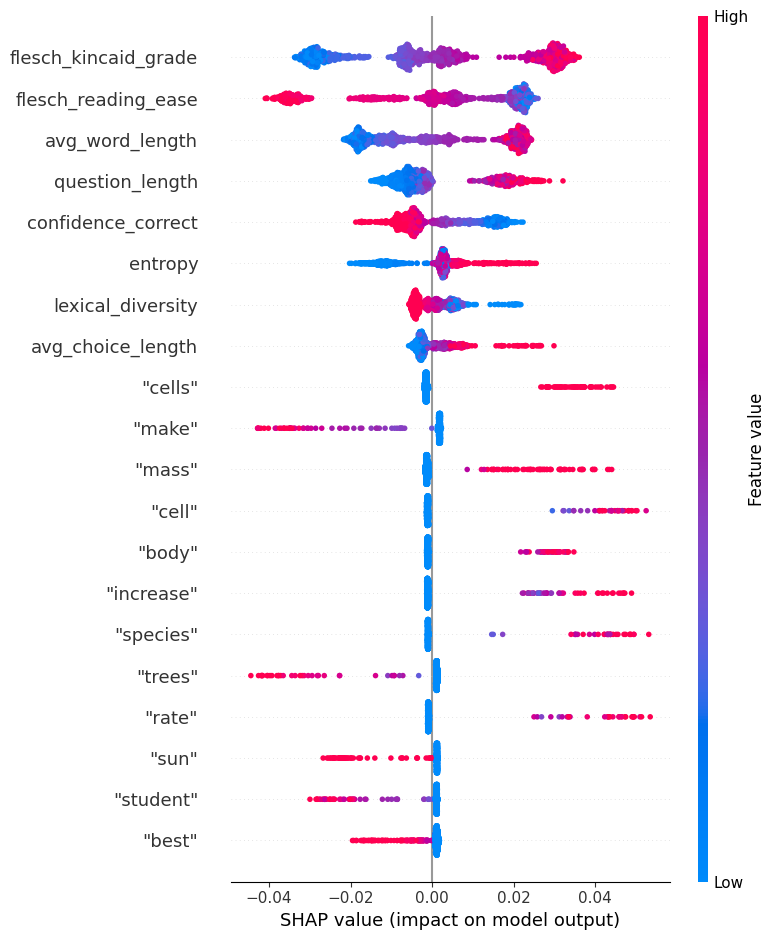

In [ ]:
extra_features = [
    "question_length", "avg_choice_length", "flesch_reading_ease",
    "flesch_kincaid_grade", "avg_word_length", "lexical_diversity",
    "entropy", "confidence_correct"
]

X_train, X_test, y_train, y_test, vectorizer = vectorize_and_add_features(train_df, test_df)
rf_model = improved_models["Random Forest"].fit(X_train, y_train)

# Create inputs
X_train = csr_matrix(X_train)
n_tfidf = len(vectorizer.get_feature_names_out())
X_tfidf = X_train[:, :n_tfidf]
X_extra = X_train[:, n_tfidf:].toarray()

plot_shap_arc(
    rf_model,
    X_tfidf,
    vectorizer,
    extra_feature_array=X_extra,
    extra_feature_names=extra_features,
    title="SHAP-Plot ARC"
)
